<a href="https://colab.research.google.com/github/HwangHanJae/Dacon_tutorial/blob/main/Dacon_iris_predict_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

타겟데이터 : sepal width (cm), petal width (cm)

평가지표 : mae

In [ ]:
#데이터 로드
import pandas as pd
import numpy as np
plt.style.use("ggplot")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataScience/Data/iris/iris_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataScience/Data/iris/iris_test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataScience/Data/iris/sample_submission.csv")

#컬럼 이름 바꾸기
train = train.rename(columns = {"sepal length (cm)" : "sepal_length",
                        "petal length (cm)" :"petal_length",
                        "sepal width (cm)":"sepal_width",
                        "petal width (cm)":"petal_width"})

test = test.rename(columns = {"sepal length (cm)":"sepal_length",
                              "petal length (cm)":"petal_length"})

EDA

In [ ]:
#라이브러리 로드 및 시각화 설정
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

plt.style.use("seaborn")
set_matplotlib_formats("svg")

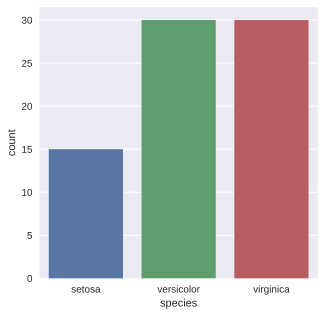

In [ ]:
#종류의 분포
plt.figure(figsize=(5,5))
sns.countplot(data=train, x='species')

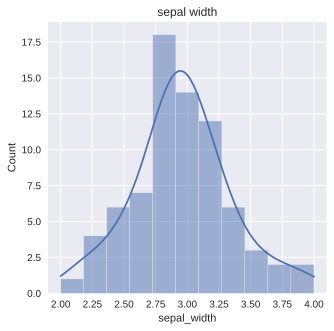

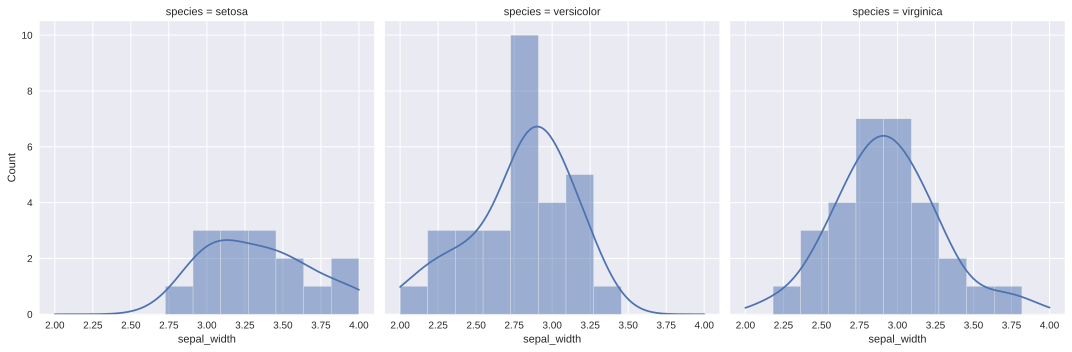

In [ ]:
#타겟데이터 분포 확인

plt.figure(figsize=(5,5))
sns.histplot(data=train, x='sepal_width', kde= True)
plt.title("sepal width")
sns.displot(data=train, x='sepal_width', col='species',kde=True)

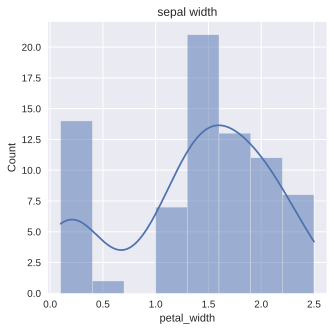

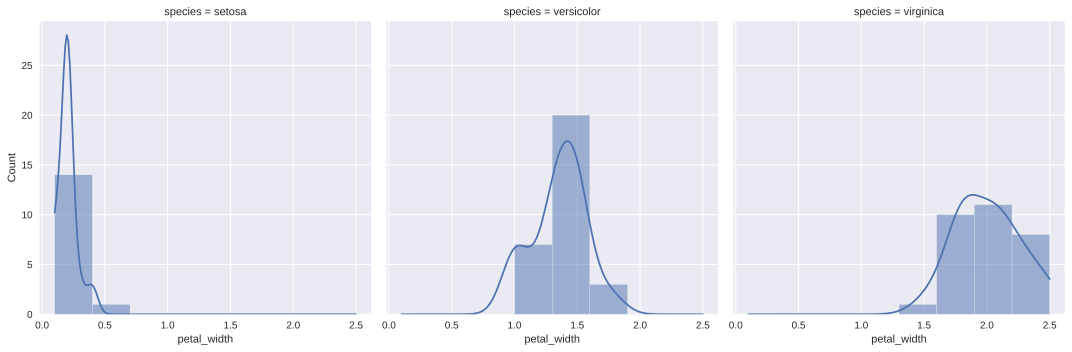

In [ ]:
#타겟데이터 분포 확인
plt.figure(figsize=(5,5))
sns.histplot(data=train, x='petal_width', kde= True)
plt.title("sepal width")
sns.displot(data=train, x='petal_width', col='species',kde=True)

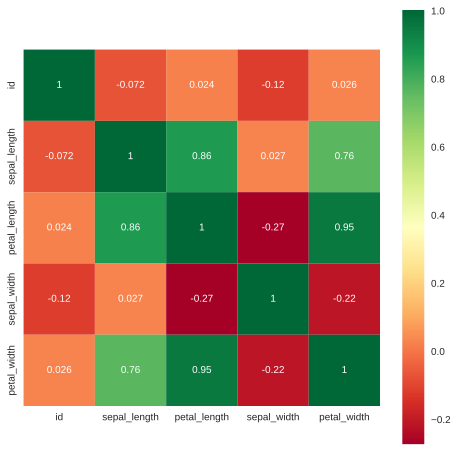

In [ ]:
#상관관계
corr = train.corr()
f, ax = plt.subplots(1,1,figsize=(8,8))
sns.heatmap(corr,annot=True, cmap="RdYlGn", square = True, ax=ax)

petal_width와 상관관계
petal_length (0.95) > sepal_length(0.76)

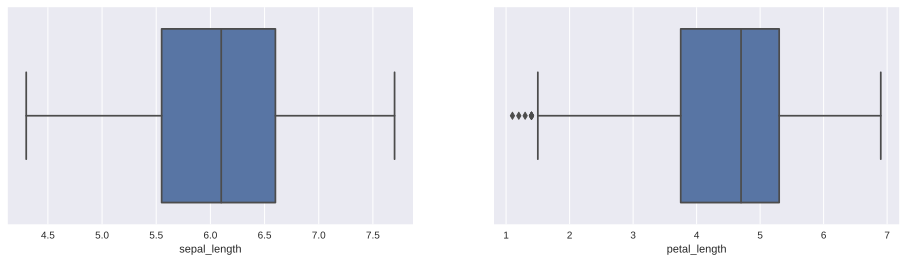

In [ ]:
#이상치 감지
f, ax= plt.subplots(1,2, figsize=(16,4))
sns.boxplot(data=train, x='sepal_length',ax=ax[0])
sns.boxplot(data=train, x='petal_length', ax=ax[1])

박스 플롯을 그려보니 petal_length에서 이상치가 감지됨

In [ ]:
train.describe()

,id,sepal_length,petal_length,sepal_width,petal_width
count,75.000000,75.000000,75.000000,75.000000,75.000000
mean,37.000000,6.044000,4.258667,2.958667,1.384000
std,21.794495,0.842653,1.615390,0.388376,0.697106
min,0.000000,4.300000,1.100000,2.000000,0.100000
25%,18.500000,5.550000,3.750000,2.800000,1.000000
50%,37.000000,6.100000,4.700000,3.000000,1.500000
75%,55.500000,6.600000,5.300000,3.200000,1.850000
max,74.000000,7.700000,6.900000,4.000000,2.500000


In [ ]:
# Q1 = train["petal_length"].describe()["25%"]
# Q3 = train["petal_length"].describe()["75%"]

# IQR = Q3-Q1
# lower = Q1 - (1.5 * IQR)
# upper = Q3 + (1.5 * IQR)
# train = train.loc[(train["petal_length"] >= lower) & (train["petal_length"] <= upper)]

이상치로 판단되는 변수들을 제외한 범위의 훈련데이터를 재생성


In [ ]:
#one-hot-encoding
train = pd.get_dummies(data=train,columns=["species"], prefix="species")
test = pd.get_dummies(data=test, columns=["species"], prefix='species')

모델링



In [ ]:
test.shape

(75, 6)

In [ ]:
drop_cols = ["id", "sepal_width","petal_width"]
X = train.drop(drop_cols, axis=1)
test = test.drop(["id"], axis=1)
y = train["sepal_width"]
test.shape

(75, 5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as MAE

rf = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

In [ ]:
#K-fold 교차검증
from sklearn.model_selection import KFold
k_fold = KFold(n_splits = 5, shuffle = True, random_state=42)

models = [rf, xgb, lgbm, knn, tree]
preds = []
results = []
for model in models:
  for i, (train_index, val_index) in enumerate(k_fold.split(X,y),1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)

    result = MAE(y_val, predict)
    results.append(result)
    print("kfold_{} : {}".format(i, result))
  print(np.mean(results, axis=0))
  print()


RandomForestRegressor
kfold_1 : 0.2520055555555565
RandomForestRegressor
kfold_2 : 0.25402222222222254
RandomForestRegressor
kfold_3 : 0.2559304761904769
RandomForestRegressor
kfold_4 : 0.18899214285714247
RandomForestRegressor
kfold_5 : 0.3272511111111117
0.255640301587302

XGBRegressor
[13:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_1 : 0.26537375450134276
XGBRegressor
[13:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_2 : 0.223320795694987
XGBRegressor
[13:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_3 : 0.24006515820821128
XGBRegressor
[13:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_4 : 0.2330327987670898
XGBRegressor
[13:39:17] WARNING: /workspace/src

파라미터 없이 교차검증을 돌렸을 때 mae 값이 낮을 수록 좋은것이기 때문

* 값이 낮다는 것은 차이가 적다는 것

knn -> lgbm -> rf 모델


In [ ]:
import numpy as np
model = knn = KNeighborsRegressor()
preds = []
results = []
for i, (train_index, val_index) in enumerate(k_fold.split(X,y),1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)

    result = MAE(y_val, predict)
    results.append(result)

    print("kfold_{} : {}".format(i, result))
    pred = model.predict(test)
    preds.append(pred)
sepal_width_predict = np.mean(preds, axis=0)
print(np.mean(results, axis=0))
print()

KNeighborsRegressor
kfold_1 : 0.2359999999999999
KNeighborsRegressor
kfold_2 : 0.22000000000000006
KNeighborsRegressor
kfold_3 : 0.22400000000000006
KNeighborsRegressor
kfold_4 : 0.1813333333333332
KNeighborsRegressor
kfold_5 : 0.3293333333333333
0.2381333333333333



In [ ]:
sepal_width_predict

array([3.524, 3.632, 3.508, 3.476, 2.716, 2.636, 3.616, 3.28 , 3.252,
       2.784, 3.252, 3.216, 2.916, 3.12 , 2.672, 2.788, 3.132, 3.044,
       2.896, 2.94 , 2.94 , 3.176, 2.592, 3.38 , 2.564, 3.176, 3.472,
       3.4  , 3.64 , 3.004, 2.592, 3.508, 3.128, 3.016, 2.94 , 3.34 ,
       3.112, 2.684, 3.316, 2.956, 3.34 , 3.272, 3.124, 3.316, 3.16 ,
       3.112, 2.896, 2.508, 3.648, 2.808, 3.316, 2.756, 2.58 , 2.796,
       3.64 , 2.876, 3.64 , 2.648, 3.272, 2.892, 2.996, 2.632, 2.98 ,
       2.944, 3.176, 3.34 , 3.016, 3.312, 3.508, 2.684, 2.6  , 3.128,
       2.94 , 2.508, 2.66 ])

In [ ]:
submission["sepal width (cm)"] = sepal_width_predict

In [ ]:
#petal_width_predict
y = train["petal_width"]

rf = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

k_fold = KFold(n_splits = 5, shuffle = True, random_state=42)

models = [rf, xgb, lgbm, knn, tree]
preds = []
results = []
for model in models:
  for i, (train_index, val_index) in enumerate(k_fold.split(X,y),1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)

    result = MAE(y_val, predict)
    results.append(result)
    print("kfold_{} : {}".format(i, result))
  print(np.mean(results, axis=0))
  print()

RandomForestRegressor
kfold_1 : 0.16889999999999988
RandomForestRegressor
kfold_2 : 0.19701444444444455
RandomForestRegressor
kfold_3 : 0.19645333333333326
RandomForestRegressor
kfold_4 : 0.17134777777777804
RandomForestRegressor
kfold_5 : 0.14745555555555548
0.17623422222222224

XGBRegressor
[13:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_1 : 0.14784110109011334
XGBRegressor
[13:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_2 : 0.18394444902737925
XGBRegressor
[13:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_3 : 0.18661981066068015
XGBRegressor
[13:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_4 : 0.1636879587173462
XGBRegressor
[13:40:03] WARNING: /worksp

rf 모델이 성능이 제일 좋음

In [ ]:
# petal_width_predict = rf.predict(test)
# submission["petal width (cm)"] = petal_width_predict

In [ ]:
# #knn : 0.273, rf = 0.180
# submission

,id,sepal width (cm),petal width (cm)
0,0,3.30,0.35550
1,1,3.30,0.32850
2,2,3.30,0.26550
3,3,3.30,0.31750
4,4,2.80,1.84725
...,...,...,...
70,70,2.54,1.06600
71,71,3.30,0.17750
72,72,3.04,2.09260
73,73,2.62,1.05200


In [ ]:
# submission.to_csv("submission_knn_rf.csv", index=False)

In [ ]:
import numpy as np
model = XGBRegressor()
preds = []
results = []
for i, (train_index, val_index) in enumerate(k_fold.split(X,y),1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)

    result = MAE(y_val, predict)
    results.append(result)

    print("kfold_{} : {}".format(i, result))
    pred = model.predict(test)
    preds.append(pred)
petal_width_predict = np.mean(preds, axis=0)
print(np.mean(results, axis=0))
print()

XGBRegressor
[13:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_1 : 0.14784110109011334
XGBRegressor
[13:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_2 : 0.18394444902737925
XGBRegressor
[13:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_3 : 0.18661981066068015
XGBRegressor
[13:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_4 : 0.1636879587173462
XGBRegressor
[13:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
kfold_5 : 0.15620774149894714
0.1676602121988932



In [ ]:
petal_width_predict

array([0.35950536, 0.19710734, 0.19914205, 0.3615918 , 1.7089632 ,
       2.0787594 , 0.19914205, 0.2009141 , 0.17759196, 1.3809649 ,
       0.18057525, 0.17382208, 1.9829432 , 2.1072955 , 1.4594715 ,
       1.8342323 , 0.21521392, 1.9971817 , 1.3976566 , 1.9337943 ,
       1.9925016 , 0.34621173, 1.1322596 , 0.24649699, 1.2457645 ,
       0.22983184, 0.3615918 , 0.21805921, 0.20129874, 2.0326831 ,
       1.1479897 , 0.2162623 , 0.19178224, 2.1525962 , 2.0215044 ,
       0.2012285 , 0.21202321, 1.4232128 , 0.24438569, 1.412256  ,
       0.2012285 , 0.20127387, 1.9314951 , 0.24438569, 2.1072955 ,
       0.20915945, 1.9535382 , 1.0010765 , 0.3527829 , 1.4099623 ,
       0.24438569, 1.4851946 , 1.2441809 , 1.4946514 , 0.20129874,
       1.6723249 , 0.20093897, 1.1851928 , 0.19841012, 1.436294  ,
       2.101618  , 1.2488416 , 1.9808147 , 1.986805  , 0.24679144,
       0.2012285 , 2.017282  , 0.20302539, 0.2162623 , 1.4232128 ,
       1.1509346 , 0.19178224, 1.9552629 , 1.0312834 , 2.08119

In [ ]:
#이상치를 제거하지 않고 모델링
#knn : 0.238, xgb = 0.167
submission["petal width (cm)"] = petal_width_predict

submission

,id,sepal width (cm),petal width (cm)
0,0,3.524,0.359505
1,1,3.632,0.197107
2,2,3.508,0.199142
3,3,3.476,0.361592
4,4,2.716,1.708963
...,...,...,...
70,70,2.600,1.150935
71,71,3.128,0.191782
72,72,2.940,1.955263
73,73,2.508,1.031283


In [ ]:
submission.to_csv("submission_knn_xgb_2.csv", index=False)